<a href="https://colab.research.google.com/github/smoreira/TensorFlow2/blob/master/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://www.ryde.nsw.gov.au/files/sharedassets/public/environment/animals/catsdogs_ban.jpg)

## Etapa 1: Instalação das dependências

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x
import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")

You are using TensorFlow version 2.2.0-rc4
You have a GPU enabled.


In [2]:
!pip install tqdm

In [0]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

## Pré-Processamento

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2020-05-09 10:38:15--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   143MB/s    in 0.5s    

2020-05-09 10:38:15 (143 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
dataset_path = "./cats_and_dogs_filtered.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

dataset_path_new = "./cats_and_dogs_filtered"
train_dir = os.path.join(dataset_path_new, "train")
validation_dir = os.path.join(dataset_path_new, "validation")

## Carregando modelo (MobileNetV2)

In [0]:
img_shape = (128,128,3)

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights = "imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

##Congelando modelo base

In [0]:
base_model.trainable = False

##Definindo novo topo da rede

In [11]:
base_model.output

<tf.Tensor 'out_relu/Identity:0' shape=(None, 4, 4, 1280) dtype=float32>

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [13]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Identity:0' shape=(None, 1280) dtype=float32>

In [0]:
predict_layer = tf.keras.layers.Dense(units=1, activation="sigmoid")(global_average_layer)

##Definindo Modelo

In [0]:
model = tf.keras.models.Model(inputs = base_model.input, outputs=predict_layer)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="binary_crossentropy",
              metrics=["accuracy"])

##Preprocessamento de imagens

In [0]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [22]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128,128), batch_size=128, class_mode="binary")
valid_generator = data_gen_train.flow_from_directory(validation_dir, target_size=(128,128), batch_size=128, class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##Treinando o modelo

In [0]:
batch_size=32
steps_per_epoch = np.ceil(train_generator.n / batch_size)
validation_steps = np.ceil(valid_generator.n / batch_size)

In [28]:
history = model.fit(train_generator, 
                    validation_data=valid_generator,
                    epochs=5,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps=validation_steps
                    )

Epoch 1/5
63/63 [==============================] - 43s 689ms/step - loss: 2.1119e-06 - accuracy: 1.0000 - val_loss: 0.4146 - val_accuracy: 0.9520
Epoch 2/5
63/63 [==============================] - 43s 675ms/step - loss: 1.7541e-06 - accuracy: 1.0000 - val_loss: 0.4195 - val_accuracy: 0.9507
Epoch 3/5
63/63 [==============================] - 42s 674ms/step - loss: 2.4809e-06 - accuracy: 1.0000 - val_loss: 0.4006 - val_accuracy: 0.9523
Epoch 4/5
63/63 [==============================] - 43s 677ms/step - loss: 1.4159e-06 - accuracy: 1.0000 - val_loss: 0.3806 - val_accuracy: 0.9538
Epoch 5/5
63/63 [==============================] - 43s 675ms/step - loss: 1.7650e-06 - accuracy: 1.0000 - val_loss: 0.4283 - val_accuracy: 0.9492


## Avaliando o modelo

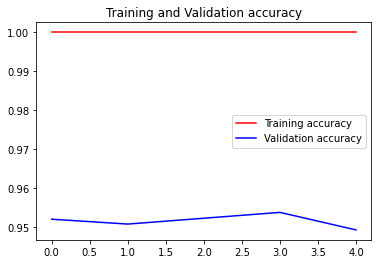

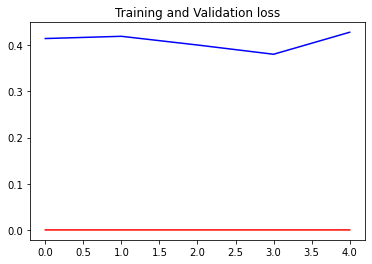

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot  ( epochs,     loss, 'r', label='Training Loss')
plt.plot  ( epochs, val_loss, 'b', label='Validation Loss')
plt.title ('Training and Validation loss')

plt.show()

## Testando a predição

A função sigmoid produz um valor entre 0 e 1. Sendo a classe 0 o gato e 1 o cachorro.

Basta definir um limite, aqui, se um score for acima de 0.5 ele pertence a classe 1 e se for abaixo ele pertence a classe 0

In [39]:
from google.colab import files
from keras.preprocessing import image

threshold = 0.5
  
uploaded = files.upload()

for fn in uploaded.keys():
 
  # imagens
  path = fn
  img = image.load_img(path, target_size=(128, 128))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)
  
  if classes > threshold:
    print('Dog')
  else:
    print('Cat')

Saving filhote4.jpeg to filhote4 (1).jpeg
filhote4.jpeg
[[0.0111049]]
Cat
